In [1]:
%matplotlib inline
!pip install git+https://github.com/perellonieto/fat-forensics.git@background_check

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import contextlib

from scipy.stats import multivariate_normal

import ipywidgets
from ipywidgets import interact
from ipywidgets import FloatSlider
from ipywidgets import IntSlider
from ipywidgets import Checkbox, ToggleButtons

seed = 42

# Avoid problems with pdfpc and fonts
plt.rc('pdf', fonttype=42)
plt.rc('ps',  fonttype=42)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (4,3)
plt.rcParams["scatter.edgecolors"] = 'k' 

# set precision of floats
np.set_printoptions(precision=2, suppress=True)

### helper functions
def affine_bias(z, mu0=0.5, mu1=0.5):
    if mu0 == mu1:
        return mu0
    return (1-z)*mu0 + z*mu1

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)
    

def ax_scatter_question(ax, x, notes, zorder=99, clip_on=True, text_size=18, color='w'):
    ax.scatter(x[:,0], x[:,1], c=color, s=500, zorder=zorder, clip_on=clip_on)

    for point, n in zip(x, notes):
        ax.annotate('{}'.format(n), xy=(point[0],point[1]), xytext=(point[0],point[1]),
                    ha="center", va="center", size=text_size, zorder=zorder, clip_on=clip_on)
        
def plot_points_predictions(fig, x, y, Z, MX1, MX2, x_predict=None, notes=None,
                            cmap=cm.plasma_r, cmap_r=cm.plasma, loc='lower right',
                            levels=None, alpha=0.7):
    x1_min, x1_max = MX1.min(), MX1.max()
    x2_min, x2_max = MX2.min(), MX2.max()
    
    ax = fig.add_subplot(1,1,1)

    print("length of unique values = {}".format(len(np.unique(Z))))
    if len(np.unique(Z)) > 1:
        # Colormap
        im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                       cmap=cmap_r, extent=(x1_min, x1_max, x2_min, x2_max),
                       alpha=alpha, vmin=0, vmax=1)

        # Contour
        CS = ax.contour(MX1, MX2, Z, levels=levels, cmap=cmap)
        ax.clabel(CS, fontsize=13, inline=1)
    else:
        print("Unique value = ", np.unique(Z)[0])
        ax.set_axis_bgcolor((1,1-np.unique(Z)[0],1-np.unique(Z)[0]))
        
    ax.scatter(x[y==0,0], x[y==0,1], c='y', alpha=0.5, label='Train. Class 1')
    ax.scatter(x[y==1,0], x[y==1,1], c='b', alpha=0.5, label='Train. Class 2')
    ax.grid(True)
    
    ax.set_xlim([x1_min,x1_max])
    ax.set_ylim([x2_min,x2_max])
    
    if x_predict is not None:
        ax_scatter_question(ax, x_predict, notes)
    ax.legend(loc=loc)
    
    return ax
    
    
def plot_points(fig, x, y, MX1, MX2, x_predict=None, notes=None, loc='upper right'):
    x1_min, x1_max = MX1.min(), MX1.max()
    x2_min, x2_max = MX2.min(), MX2.max()
    
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x[y==0,0], x[y==0,1], c='y', alpha=0.5, label='Train. Class 1')
    ax.scatter(x[y==1,0], x[y==1,1], c='b', alpha=0.5, label='Train. Class 2')
    ax.grid(True)
    ax.legend(loc=loc)
    
    ax.set_xlim([x1_min,x1_max])
    ax.set_ylim([x2_min,x2_max])
    

# Definition of some colors for the heatmaps
from matplotlib.colors import LinearSegmentedColormap
    
cm_ra = {'red': ((0.0, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),
        'green': ((0.0, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),
        'blue': ((0.0, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),
        'alpha': ((0.0, 0.0, 0.0),
                  (1.0, 1.0, 1.0))}
red_alpha = LinearSegmentedColormap('RedAlpha1', cm_ra)

cm_ya = {'red': ((0.0, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),
        'green': ((0.0, 1.0, 1.0),
                  (1.0, 1.0, 1.0)),
        'blue': ((0.0, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),
        'alpha': ((0.0, 0.0, 0.0),
                  (1.0, 1.0, 1.0))}
yellow_alpha = LinearSegmentedColormap('YellowAlpha1', cm_ya)

cm_ba = {'red': ((0.0, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
        'green': ((0.0, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),
        'blue': ((0.0, 1.0, 1.0),
                  (1.0, 1.0, 1.0)),
        'alpha': ((0.0, 0.0, 0.0),
                  (1.0, 1.0, 1.0))}
blue_alpha = LinearSegmentedColormap('BlueAlpha1', cm_ba)

cmaps = [yellow_alpha, blue_alpha, red_alpha]

def plot_probabilities(p, extent=None, alpha=0.7):
    delta = int(np.sqrt(p.shape[0]))
    for i in range(p.shape[1]):
        example = p[:,i].flatten()[0]
        if not np.allclose(p[:,i], example):
            plt.imshow(p[:,i].reshape((delta,delta)), interpolation='bilinear',
                origin='lower', cmap=cmaps[i], extent=extent, alpha=alpha,
                vmin=0, vmax=1)
        else:
            # FIXME the unique value could be any posterior probability
            # now it is considering only the background (red)
            print("Unique value = ", example)
            #ax.set_axis_bgcolor((1,1-example,1-example))
            
            
def is_inside_rectangle(rectangle, point, delta=0.1):
    '''
    rectangle: (bottom-left, top-left, top-right, bottom-right) where each element is a two coordinate point (x,y)
    point: two coordinate point (x, y)
    delta: float (error margin for floats)
    '''
    return ((point[0]+delta >= rectangle[0,0]) and (point[0]-delta <= rectangle[2,0]) and
            (point[1]+delta >= rectangle[0,1]) and (point[1]-delta <= rectangle[2,1]))

def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    https://stackoverflow.com/questions/3252194/numpy-and-line-intersections
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return np.array((x/z, y/z))

def get_two_intersections(rectangle, line):
    '''
    rectangle: (bottom-left, top-left, top-right, bottom-right) where each element is a two coordinate point (x,y)
    line: (first-point, second-point) where each point is a two coordinate point (x, y)
    '''
    point1, point2 = line
            
    new_point_1 = get_intersect(point1, point2, rectangle[0], rectangle[1])
    if not is_inside_rectangle(rectangle, new_point_1):
        new_point_1 = get_intersect(point1, point2, rectangle[3], rectangle[0])
        
    if not is_inside_rectangle(rectangle, new_point_1):
        raise Exception('The lines do not intersect')
            
    new_point_2 = get_intersect(point1, point2, rectangle[1], rectangle[2])
    if not is_inside_rectangle(rectangle, new_point_2):
        new_point_2 = get_intersect(point1, point2, rectangle[2], rectangle[3])
        
    if not is_inside_rectangle(rectangle, new_point_2):
        raise Exception('{} not inside the rectangle {}'.format(new_point_2, rectangle))
        
    return new_point_1, new_point_2

def linspace_between_points(start, stop, N=50, endpoint=True):
    '''
    https://stackoverflow.com/questions/40624409/vectorized-numpy-linspace-for-multiple-start-and-stop-values
    '''
    if endpoint==1:
        divisor = N-1
    else:
        divisor = N
    steps = (1.0/divisor) * (stop - start)
    return (steps[:,None]*np.arange(N) + start[:,None]).T

  Cloning https://github.com/perellonieto/fat-forensics.git (to background_check) to /tmp/pip-79ykqov0-build


# Generate some random samples

In this case both classes are drawn from two Gaussian distributions

(-5.0, 7.0)

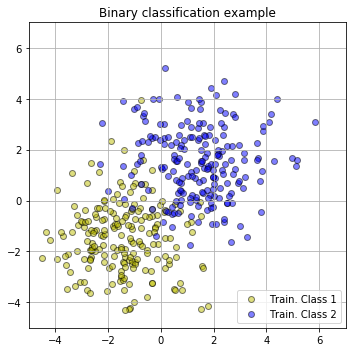

In [2]:
n_samples = 200 * 2
prior = [0.5, 0.5]
means = np.array([[-1.5, -1.5], [1.5, 1.5]])

model_c1 = multivariate_normal(mean=means[0], cov=np.array([[2,0], [0,2]]))
model_c2 = multivariate_normal(mean=means[1], cov=np.array([[2,0], [0,2]]))

np.random.seed(seed)
N = 200*2
X = np.concatenate((model_c1.rvs(int(n_samples * prior[0])),
                    model_c2.rvs(int(n_samples * prior[1]))))
y = np.concatenate((np.zeros(int(n_samples * prior[0])),
                    np.ones(int(n_samples * prior[1]))))


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_title('Binary classification example')
ax.scatter(X[y==0,0], X[y==0,1], c='y', alpha=0.5, label='Train. Class 1')
ax.scatter(X[y==1,0], X[y==1,1], c='b', alpha=0.5, label='Train. Class 2')
ax.grid(True)
        
ax.legend(loc='lower right')

x1_min, x1_max = (-5.0, 7.0)
x2_min, x2_max = (-5.0, 7.0)

ax.set_xlim([x1_min, x1_max])
ax.set_ylim([x2_min, x2_max])

# Train a classifier and a relative density estimator

The classifier needs to output probabilities, and the relative density estimator can be any function that i affine to an approximate of the density of the data with values restricted between 0 and 1

In [3]:
import fatf.utils.models as fatf_models
from fatf.accountability.models.background_check import BackgroundCheck
from fatf.accountability.models.background_check import update_posterior

from fatf.utils.data.density import GaussianRelativeDensityEstimator

# Train probabilistic classifier
#clf = fatf_models.KNN()
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

clf = LogisticRegression()
#clf = SVC(gamma='auto', probability=True)

clf.fit(X, y)

# Train a relative density estimator
rde = GaussianRelativeDensityEstimator()
rde.fit(X)

# Create Background Check
bc = BackgroundCheck(clf, rde)

20-Feb-02 14:02:52 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.
/home/miquel/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [4]:
# Create a grid to visualize the predictions of our model
delta = 0.25 # Lower values are computationally more expensive
x1_grid = np.arange(x1_min, x1_max, delta)
x2_grid = np.arange(x2_min, x2_max, delta)
MX1, MX2 = np.meshgrid(x1_grid, x2_grid)
x_grid = np.asarray([MX1.flatten(),MX2.flatten()]).T
extent=(x1_min, x1_max, x2_min, x2_max)

print(x_grid.shape)
print(np.sqrt(x_grid.shape[0]))

(2304, 2)
48.0


In [17]:
import numpy as np

rectangle = np.array([[x1_min, x2_min],[x1_min, x2_max],[x1_max,x2_max],[x1_max, x2_min]])
samples_x = X
samples_y = y

def plot_feature_space(ax, x_line, samples_x, samples_y, show_samples, contourlines,
                       extent, bc, clf, x_grid, mu0, mu1, x, y):       
        if show_samples:
            ax.scatter(samples_x[samples_y==0,0], samples_x[samples_y==0,1],
                       c='y', alpha=0.5, label='Train. Class 1')
            ax.scatter(samples_x[samples_y==1,0], samples_x[samples_y==1,1],
                       c='b', alpha=0.5, label='Train. Class 2')

        ax.set_title("Feature space")

        extent=(x1_min, x1_max, x2_min, x2_max)
        if contourlines == 'P(b|x)':
            p_c1_c2_b_g_x = bc.predict_proba(x_grid, mu0=mu0, mu1=mu1)
            plot_probabilities(p_c1_c2_b_g_x, extent=extent)
            CS = ax.contour(MX1, MX2, p_c1_c2_b_g_x[:, -1].reshape(MX1.shape), cmap=cm.Reds_r)
        else:
            p_c1_c2_g_f_x = clf.predict_proba(x_grid)
            plot_probabilities(p_c1_c2_g_f_x, extent=extent)
            CS = ax.contour(MX1, MX2, p_c1_c2_g_f_x[:, -1].reshape(MX1.shape), cmap=cm.plasma)
        ax.grid(True)

        ax.plot(x_line[:,0], x_line[:,1], 'k.')
        ax.clabel(CS, fontsize=13, inline=1)
        ax.scatter(x, y, marker='o', s=200, color='w', edgecolors='k', zorder=99)
        #ax_scatter_question(ax, np.array([[x, y]]), ['?'], zorder=99)
        # TODO remove this limits and specify the correct x_line
        ax.set_xlim([extent[0], extent[1]])
        ax.set_ylim([extent[2], extent[3]])
    
    
def plot_classifier_posteriors(ax, x_line, p_c1_c2_g_f_x, q_x, q_nearest_x_idx):
    '''
    x_line: linespace in the feature space
    p_c1_c2_g_f_x: P(C=y|f, x) posterior probabilities from the original classifier
    q_x: x coordinate of the question point
    q_y: 
    '''
    ax.set_title('Post. prob. $C_1$ vs $C_2$ given $foreground$')
    ax.plot(x_line[:, 0], p_c1_c2_g_f_x[:, 0], color='y', label='$p(C_1|f,x)$', linewidth=3)
    ax.plot(x_line[:, 0], p_c1_c2_g_f_x[:, 1], color='b', label='$p(C_2|f,x)$', linewidth=3)
    ax.scatter(q_x, p_c1_c2_g_f_x[q_nearest_x_idx, 0], marker='o',
               s=150, color='y', edgecolors='k', zorder=99)
    ax.scatter(q_x, p_c1_c2_g_f_x[q_nearest_x_idx, 1], marker='o',
               s=150, color='b', edgecolors='k', zorder=99)
    ax.axvline(q_x, color='gray')
    ax.set_ylim([0,1])
    ax.set_xlim([x_line[0, 0], x_line[-1, 0]])
    ax.set_xticklabels([])
    ax.legend(loc='upper right', labelspacing=0.1)
    ax.grid(True)
    

def plot_relative_densities(ax, x_line, q_f, q_b, q_x, q_nearest_x_idx):
    ax.set_title('Relative densities for $foreground$ and $background$')
    ax.plot(x_line[:, 0], q_f, color='g', label='$q_f(x)$', linewidth=3)
    ax.plot(x_line[:, 0], q_b, color='r', label='$q_b(x)$', linewidth=3)
    ax.scatter(q_x, q_f[q_nearest_x_idx], marker='o',
               s=150, color='g', edgecolors='k', zorder=99)
    ax.scatter(q_x, q_b[q_nearest_x_idx], marker='o',
               s=150, color='r', edgecolors='k', zorder=99)
    ax.axvline(q_x, color='gray')
    ax.set_ylim([0,1])
    ax.set_xlim([x_line[0, 0], x_line[-1, 0]])
    ax.set_xticklabels([])
    ax.legend(loc='upper right', labelspacing=0.1)
    ax.grid(True)

    
def plot_background_check_posteriors(ax, x_line, p_c1_c2_b_g_x, q_x, q_nearest_x_idx):
    ax.set_title('Post. prob. $C_1$ vs $C_2$ vs $background$')
    ax.plot(x_line[:, 0], p_c1_c2_b_g_x[:, 0], color='y', label='$p(C_1|f,x)$', linewidth=3)
    ax.plot(x_line[:, 0], p_c1_c2_b_g_x[:, 1], color='b', label='$p(C_2|f,x)$', linewidth=3)
    ax.plot(x_line[:, 0], p_c1_c2_b_g_x[:, 2], color='r', label='$p(b|x)$', linewidth=3)
    ax.scatter(q_x, p_c1_c2_b_g_x[q_nearest_x_idx, 0], marker='o',
               s=150, color='y', edgecolors='k', zorder=99)
    ax.scatter(q_x, p_c1_c2_b_g_x[q_nearest_x_idx, 1], marker='o',
               s=150, color='b', edgecolors='k', zorder=99)
    ax.scatter(q_x, p_c1_c2_b_g_x[q_nearest_x_idx, 2], marker='o',
               s=150, color='r', edgecolors='k', zorder=99)
    ax.axvline(q_x, color='gray')
    ax.set_ylim([0,1])
    ax.set_xlim([x_line[0, 0], x_line[-1, 0]])
    #ax4.set_xticks([])
    ax.legend(loc='upper right', labelspacing=0.1)
    ax.grid(True)


def select_default_mus(mu0, mu1, example):
    if example == 'Confidence (.5, .5)':
        mu0 = mu1 = 0.5
    elif example == 'Outlier (1, 0)':
        mu0 = 1
        mu1 = 0
    elif example == 'Cautious (0, .7)':
        mu0 = 0
        mu1 = 0.7
        
    if mu0 == 0:
        mu0 = 1e-8
    return mu0, mu1


def find_nearest(array, value, return_idx=True):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if return_idx:
        return idx
    return array[idx]


def plot_background_check_demo(mu0, mu1, q_x, q_y, show_samples, contourlines='P(b|x)', example='Other'):
    mu0, mu1 = select_default_mus(mu0, mu1, example)

    new_point_1, new_point_2 = get_two_intersections(rectangle, (means[0]+[q_x, q_y], means[1]+[q_x, q_y]))

    x_line = linspace_between_points(new_point_1, new_point_2)
    q_nearest_x_idx = find_nearest(x_line[:,0], q_x)
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,2,1)
    plot_feature_space(ax, x_line, samples_x, samples_y, show_samples, contourlines,
                       extent, bc, clf, x_grid, mu0, mu1, q_x, q_y)

    ax2 = fig.add_subplot(3,2,2)
    p_c1_c2_g_f_x = clf.predict_proba(x_line)
    plot_classifier_posteriors(ax2, x_line, p_c1_c2_g_f_x, q_x, q_nearest_x_idx)
    
    ax3 = fig.add_subplot(3,2,4)
    q_f = bc.relative_density(x_line)
    q_b = q_f * mu1 + (1 - q_f) * mu0
    plot_relative_densities(ax3, x_line, q_f, q_b, q_x, q_nearest_x_idx)
    
    ax4 = fig.add_subplot(3,2,6)
    p_c1_c2_b_g_x = bc.predict_proba(x_line, mu0=mu0, mu1=mu1)
    plot_background_check_posteriors(ax4, x_line, p_c1_c2_b_g_x, q_x, q_nearest_x_idx)
    
from ipywidgets import interactive

interactive(plot_background_check_demo,
         {'manual': False},
         example=ToggleButtons(options=['Slider (mu0, mu1)', 'Confidence (.5, .5)',
                                        'Outlier (1, 0)', 'Cautious (0, .7)', ],
                               description='Example'),
         show_samples=Checkbox(value=True, description='Show samples'),
         contourlines=ToggleButtons(options=['P(C_2|f,x)', 'P(b|x)'],
                                    description='Contourlines'),
         mu0=FloatSlider(value=0.5, min=0.0, max=1, step=0.1, continuous_update=False),
         mu1=FloatSlider(value=0.5, min=0.0, max=1, step=0.1, continuous_update=False),
         q_x=IntSlider(min=-4, max=6, step=2, value=2, continuous_update=False),
         q_y=IntSlider(min=-4, max=6, step=2, value=2, continuous_update=False),                                        
        )

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='mu0', max=1.0), FloatSlider…